# Image Classification: Clean vs No-clean PV Modules

In [39]:
# importing standard libraries
import os
import numpy as np
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

# importing model libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import BinaryAccuracy

mpl.rcParams["figure.figsize"] = (8,6)

plt.style.use("fivethirtyeight")

print(os.sys.version)
print(torch.__version__)

3.8.10 (v3.8.10:3d8993a744, May  3 2021, 09:09:08) 
[Clang 12.0.5 (clang-1205.0.22.9)]
2.0.1


In [40]:
data_path = "CleanDustyPV"
class_names = ["clean", "dusty"]

User define function to retreive the data for the directory of interest returning a list with all image names in the directory.

In [41]:
def file_retreiver(DIR:str)->list:
    """
    This function is defined to return a list with all image names in the directory
    of one of the image classes. 
    
    Args:
        DIR (sting) : directory name containing full path to image class directory.

    Returns:
        list : list with all image names in the directory given by DIR
    """
    fl = os.listdir(DIR)
    return fl

In [42]:
# getting images from training set 
train_pic_clean = file_retreiver(DIR=data_path+'/'+'train'+'/'+class_names[0])
train_pic_dirty = file_retreiver(DIR=data_path+'/'+'train'+'/'+class_names[1])

# printing the number of samples in the training set
ntrain_samples = len(train_pic_clean) + len(train_pic_dirty)
print(f"There are {ntrain_samples} training samples")
print("there are {} clean images in the trainig set".format(len(train_pic_clean)))
print("there are {} dirty images in the trainig set".format(len(train_pic_dirty)))

There are 2049 training samples
there are 1194 clean images in the trainig set
there are 855 dirty images in the trainig set


In [43]:
# number of positive (pneumonia) and negative (normal) samples
n_pos = len(train_pic_dirty)
n_neg = len(train_pic_clean)
print(f"there are {n_pos} positve samples and {n_neg} negative samples in the train dataset.")

there are 855 positve samples and 1194 negative samples in the train dataset.


In [44]:
# negative class weight: pneumonia / normal
pos_w =  n_neg / n_pos
print(f"the weight for the imbalanced label is {pos_w}")

the weight for the imbalanced label is 1.3964912280701753


In [45]:
def img_viewer(idx_list:list, images_loc:str, images_list:list, title:str=None) -> None:
    """_summary_

    Args:
        idx_list (list): _description_
        images_loc (str): _description_
        images_list (list): _description_
        title (str): _description_
    """
    fig, ax = plt.subplots(figsize=(11,9), ncols=len(idx_list))
    for i, idx in enumerate(idx_list):
        img = plt.imread(images_loc + '/' + images_list[idx])
        ax[i].imshow(img)
    if title != None:
        fig.suptitle(title)
    fig.tight_layout()
    plt.show() 

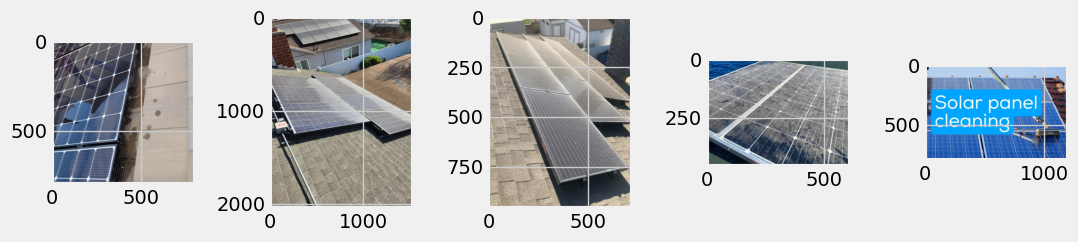

In [46]:
# view random sample images from Clean folders
rand_im_idx = np.random.randint(0, len(train_pic_dirty), size=5)

img_viewer(
    idx_list=rand_im_idx, images_loc=data_path+'/'+'train'+'/'+class_names[1], images_list=train_pic_dirty, #title="Dirty PV Modules"
    )

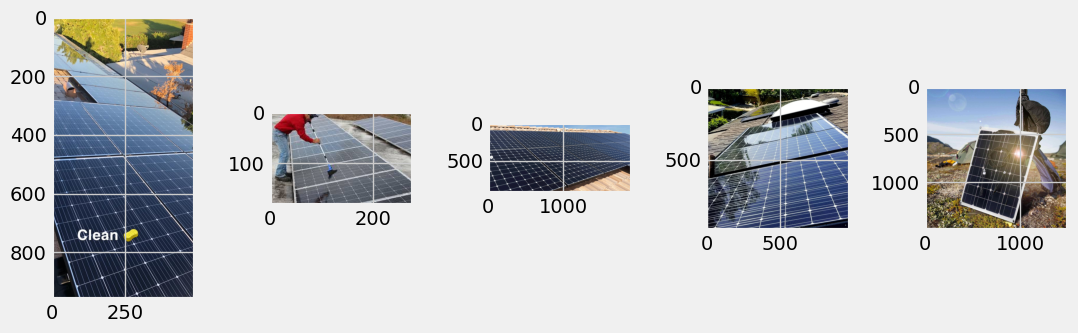

In [47]:
img_viewer(
    idx_list=rand_im_idx, images_loc=data_path+'/'+'train'+'/'+class_names[0], images_list=train_pic_clean, #title="Clean PV Modules"
    )

In [48]:
clean_im = [os.path.join(data_path+'/'+'train'+'/'+class_names[0], im) for im in train_pic_clean]
dirty_im = [os.path.join(data_path+'/'+'train'+'/'+class_names[1], im) for im in train_pic_dirty]
clean_im.extend(dirty_im)
all_train_im = clean_im
print(len(all_train_im))

2049


In [49]:
ima = Image.open("/Users/danieldiazalmeida/Documents/Kaggle/CleanDustyPV/train/clean/Imgclean_2_0.jpg")
#plt.show()

In [50]:
print(ima.mode == "CMYK")
rgb_ima = ima.convert("RGB")
rgb_ima.mode == "RGB"

False


True

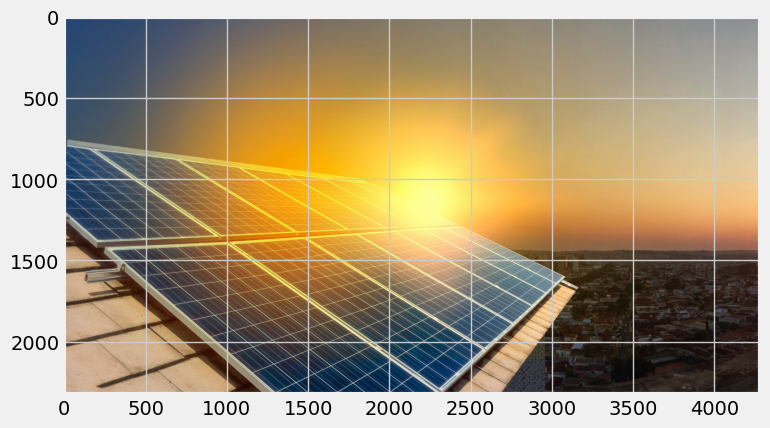

In [51]:
plt.imshow((np.array(rgb_ima.getdata())/255.).reshape(rgb_ima.size[1], rgb_ima.size[0],3))#.shape

In [52]:
def loader_apply(loader, func, reduce='sum'):
    """_summary_

    Args:
        loader (_type_): _description_
        func (_type_): _description_
        reduce (str, optional): _description_. Defaults to 'sum'.

    Returns:
        _type_: _description_
    """
    results = [func(x,y) for i, (x,y) in enumerate(loader)]
    results = torch.stack(results, axis=0)
    
    if reduce == 'sum':
        results = results.sum(axis=0)
    if reduce == 'mean':
        results = results.float().mean(axis=0)
    
    return results


def channel_statistics(images, labels):
    """_summary_

    Args:
        images (_type_): _description_
        labels (_type_): _description_

    Returns:
        _type_: _description_
    """
    n_samples, n_channels, n_height, n_width = images.size()
    
    flatten_per_channel = images.reshape(n_samples, n_channels, -1)
    
    means = flatten_per_channel.mean(axis=2)
    stds = flatten_per_channel.std(axis=2)
    
    sum_means = means.sum(axis=0)
    sum_stds = stds.sum(axis=0)
    
    n_samples = torch.tensor([n_samples]*n_channels).float()
    
    #norm_mean = total_means / total_samples
    #norm_std = total_stds / total_samples
    
    return torch.stack([n_samples, sum_means, sum_stds], axis=0)


def images_normalizer(loader):
    """_summary_

    Args:
        loader (_type_): _description_

    Returns:
        _type_: _description_
    """
    total_samples, total_means, total_std = loader_apply(
        loader=loader
        ,func=channel_statistics
    )
    norm_mean = total_means / total_samples
    norm_std = total_std / total_samples
    
    return {"mean":norm_mean, "std":norm_std}

In [53]:
temp_transforms = transforms.Compose(
    [transforms.Resize(size=(28,28))
    ,transforms.ToTensor()]
)
temp_dataset = datasets.ImageFolder(
    root="CleanDustyPV/train"
    ,transform=temp_transforms
)

In [54]:
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

In [55]:
temp_loader = DataLoader(temp_dataset, batch_size=16)
first_im, first_label = next(iter(temp_loader))
channel_statistics(first_im, first_label)

tensor([[16.0000, 16.0000, 16.0000],
        [ 6.6786,  6.6520,  7.0937],
        [ 2.9630,  2.6100,  2.7556]])

In [56]:
normalizer = images_normalizer(temp_loader)
normalizer

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


{'mean': tensor([0.4575, 0.4746, 0.5002]),
 'std': tensor([0.1915, 0.1757, 0.1782])}

In [62]:
train_transformers = transforms.Compose([
    transforms.Resize(size=(100, 100))
    ,transforms.Grayscale(num_output_channels=1)
    ,transforms.RandomPerspective()
    ,transforms.RandomHorizontalFlip()
    ,transforms.RandomVerticalFlip(p=0.5)
    ,transforms.RandomRotation(45)
    ,transforms.ToTensor()
    ,transforms.Normalize(mean=normalizer["mean"][0]
                          ,std=normalizer["std"][0])
])

test_transformers = transforms.Compose([
    transforms.Resize(size=(100, 100))
    ,transforms.Grayscale(num_output_channels=1)
    ,transforms.ToTensor()
    ,transforms.Normalize(mean=normalizer["mean"][0]
                          ,std=normalizer["std"][0])

])

In [85]:
g = torch.Generator().manual_seed(42)
train_dataset = datasets.ImageFolder(
    root="CleanDustyPV/train"
    ,transform=train_transformers
)

train_loader = DataLoader(train_dataset,
                          batch_size=16, 
                          shuffle=True, generator=g)

test_dataset = datasets.ImageFolder(
    root="CleanDustyPV/test"
    ,transform=test_transformers
)

val_dataset, test_dataset_ = random_split(test_dataset, [.80, .20], generator=g)

val_loader = DataLoader(val_dataset, 
                        batch_size=16, 
                        shuffle=False)


test_loader = DataLoader(test_dataset_, 
                         batch_size=16, 
                         shuffle=False)


In [86]:
test_dataset.class_to_idx.items()

dict_items([('clean', 0), ('dusty', 1)])

In [87]:
class_names = train_dataset.classes

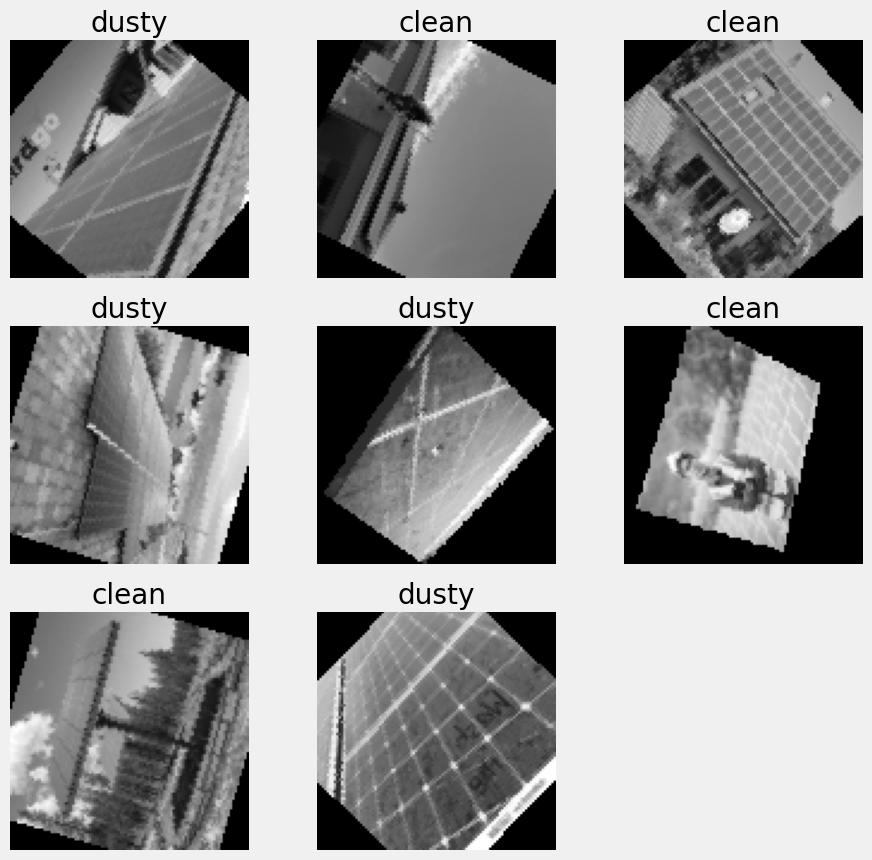

In [88]:
plt.figure(figsize=(10,10))

for i in range(8):
    first_im, first_label = next(iter(train_loader))
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(first_im[i].numpy().transpose(), cmap='gray')
    plt.title(class_names[first_label[i]])
    plt.axis("off")
        

In [89]:
from torch import mps

# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [90]:
device = torch.device("mps")
device

device(type='mps')

In [91]:
class ImageClassifier(nn.Module):
    def __init__(self, weight_init=False):
        super(ImageClassifier, self).__init__()
        self.conv1 =  nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1, stride=2)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=1)
        
        # H_in = 7, dilatatio=1, kernelsize=3, stride=2, padding=1
        # output= ((H_in + 2 * padding - dilatation * (kernel_size - 1) - 1)/stride + 1) = 3
        self.classifier = nn.Sequential(
            nn.Linear(in_features=5*5*32, out_features=16)
            ,nn.ELU()
            ,nn.Linear(in_features=16, out_features=1)
        )
    
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.pool(x)
        
        x = F.elu(self.conv2(x))
        x = self.pool(x)
        
        x = F.elu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        
        x = self.classifier(x)
        return x

In [92]:
model = ImageClassifier().to(device=device)

In [93]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_w))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=.9)

In [94]:
# initialize metric
train_metric = BinaryAccuracy().to(device=device)
val_metric = BinaryAccuracy().to(device=device)

def training_step(model, train_loader, val_loader, optim, train_acc, val_acc, epoch):
    train_loss_list = []
    val_loss_list = []

    for i in range(epoch):
        training_loss = 0.0
        validation_loss = 0.0

        # put model in training mode
        model.train()
        for img_batch, label in train_loader:
            img_batch = img_batch.to(device=device)
            label = label.to(device=device)
            
            logit = model(img_batch).view(-1)
            loss = criterion(logit, label.float())
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            training_loss += loss.item()
            train_acc(logit, label)
            #print(f"Accuracy on batch {i}: {acc}")

        # metric on all batches using custom accumulation
        total_train_accuracy = train_acc.compute()

        # put model in evaluation mode
        model.eval()
        # speed up the forward pass
        with torch.no_grad():
            for img_batch, label in val_loader:
                img_batch = img_batch.to(device=device)
                label = label.to(device=device)
                
                label_hat = model(img_batch).view(-1)
                val_loss = criterion(label_hat, label.float())
                
                validation_loss += val_loss.item()
                val_acc(label_hat, label)
                #print(f"Accuracy on batch {i}: {acc}")

        # metric on all batches using custom accumulation
        total_valid_accuracy = val_acc.compute()

        if i%2==0:

            # metric on all batches using custom accumulation
            print(
                f"Epoch: {i+1}"
                f"\nAccuracy on training data: {100*total_train_accuracy}"
                f"\nThe train loss is {training_loss / len(train_loader)}"
                f"\nAccuracy on validation data: {100*total_valid_accuracy}"
                f"\nThe validation loss is {validation_loss / len(val_loader)}"
            )

            val_loss_list.append(validation_loss / len(val_loader))
            train_loss_list.append(training_loss / len(train_loader))

        # Reseting internal state such that metric ready for new data
        train_acc.reset()
        # Reseting internal state such that metric ready for new data
        val_acc.reset()


In [95]:
EPOCHS = 21

training_step(
    model, 
    train_loader=train_loader, val_loader=val_loader, 
    optim=optimizer, 
    train_acc=train_metric, val_acc=val_metric, 
    epoch=EPOCHS)

Epoch: 1
Accuracy on training data: 0.5861395597457886
The train loss is 0.8057090330448596
Accuracy on validation data: 0.6642335653305054
The validation loss is 0.7340924281340379
Epoch: 3
Accuracy on training data: 0.659834086894989
The train loss is 0.7255839784321618
Accuracy on validation data: 0.6739659309387207
The validation loss is 0.7486762576378309
Epoch: 5
Accuracy on training data: 0.6700829863548279
The train loss is 0.7115676427397747
Accuracy on validation data: 0.669099748134613
The validation loss is 0.709882915019989
Epoch: 7
Accuracy on training data: 0.669594943523407
The train loss is 0.707891279969234
Accuracy on validation data: 0.7007299065589905
The validation loss is 0.7226417583341782
Epoch: 9
Accuracy on training data: 0.6832601428031921
The train loss is 0.6949133521619938
Accuracy on validation data: 0.6180048584938049
The validation loss is 0.7153139658845388
Epoch: 11
Accuracy on training data: 0.6832601428031921
The train loss is 0.6973869929285829
Ac

In [110]:
# Define precision metric
metric_accuracy = BinaryAccuracy(multidim_average='samplewise').to(device=device)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        metric_accuracy(outputs, labels.view(-1,1))
precision = metric_accuracy.compute()

precision_per_class = {
    k: precision[v].item()
    for k, v 
    in test_dataset.class_to_idx.items()
}

print(precision_per_class)

{'clean': 1.0, 'dusty': 1.0}


In [109]:
# Define precision metric
metric_accuracy = BinaryAccuracy(multidim_average='global').to(device=device)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images).view(-1)
        metric_accuracy(outputs, labels)
precision = metric_accuracy.compute()

print(100*precision.cpu())

tensor(80.3922)


```python
# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="micro")
metric_recall = Recall(task="multiclass", num_classes=7, average="micro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")


# Define precision metric
metric_precision = Precision(
    task='multiclass', num_classes=7, average=None
)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}
print(precision_per_class)


# Define MSE metric
mse = torchmetrics.MeanSquaredError()

net.eval()
with torch.no_grad():
    for seqs, labels in dataloader_test:
        seqs = seqs.view(32, 96, 1)
        # Pass seqs to net and squeeze the result
        outputs = net(seqs)
        mse(outputs, labels)

# Compute final metric value
test_mse = mse.compute()
print(f"Test MSE: {test_mse}")
```
